In [150]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
from scipy.special import expit as sigmoid
np.set_printoptions(precision=2)

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 500  # that's how many of EACH digit there is. Can go as high as... what, 500?

vis_train_pats = flatten_dataset(load_mnist_digit(3,dataset_size))
for i in []:
    vis_train_pats = np.vstack((vis_train_pats, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [151]:
print (vis_train_pats.shape)
num_pats = vis_train_pats.shape[0]
rand_order = rng.permutation(np.arange(num_pats))
vis_train_pats = vis_train_pats[rand_order]
num_visibles = vis_train_pats.shape[1]
# THIS WRITES LIST OF DIGIT IMAGES AS A CSV TO A PLAIN TXT FILE
# np.savetxt(fname='mnist_500_each_digit.txt', X=vis_train_pats, fmt='%.2f', delimiter=',')

(500, 784)


## Show some examples....

(500, 784)


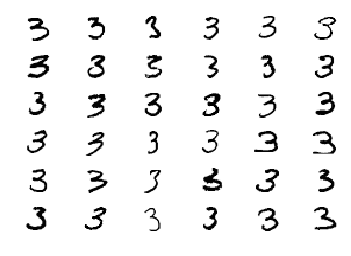

In [152]:
print(vis_train_pats.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
        plt.imshow(vis_train_pats[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

## Do some learning, using CD1 (contrastive divergence)

In [153]:
import time

def train(indata, num_hiddens, wgts, changes, num_iterations, rate, momentum, L1_penalty, minibatch_size, DROPOUT, VERBOSE=False):
    W, hid_bias, vis_bias = wgts
    W_change, hid_bias_change, vis_bias_change = changes
    announce_every = num_iterations / 5

    start = time.time()
    rand_order = rng.permutation(np.arange(num_pats))

    for t in range(num_iterations+1):
        if DROPOUT:  dropout = rng.randint(2, size=(minibatch_size, num_hiddens))            
        start_index = 0
        while start_index < num_pats-1:
            #print('start index: %d' % start_index)
            next_index = min(start_index + minibatch_size, num_pats)
            vis_minibatch = indata[start_index : next_index]
            start_index = next_index  # ready for next time

            # push visible pats into hidden 
            hid_prob1 = sigmoid(np.dot(vis_minibatch, W.T) + hid_bias)
            hid_first = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
            if DROPOUT: hid_first = hid_first * dropout

            # push hidden pats into visible 
            vis_prob1 = sigmoid(np.dot(hid_first, W) + vis_bias)
            vis_reconstruction = vis_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

            # push visible pats into hidden 
            hid_prob1 = sigmoid(np.dot(vis_reconstruction, W.T) + hid_bias)
            hid_second = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))

            # Einstein alternative suggested by Paul Mathews.
            Hebb = np.einsum('ij,ik->jk', hid_first, vis_minibatch) 
            AntiHebb = np.einsum('ij,ik->jk', hid_second, vis_reconstruction) 

            W_change = rate * (Hebb - AntiHebb)/minibatch_size  +  momentum * W_change
            W += W_change - L1_penalty * np.sign(W)

            # Now we have to do the visible and hidden bias weights as well.
            hid_bias_change = rate * (hid_first.mean(0) - hid_second.mean(0))   +  momentum * hid_bias_change
            hid_bias += hid_bias_change
            vis_bias_change = rate * (vis_minibatch.mean(0) - vis_reconstruction.mean(0))   +  momentum * vis_bias_change
            vis_bias += vis_bias_change
            
        if (t % announce_every == 0): 
            C = np.power(vis_reconstruction - vis_minibatch, 2.0).mean()
            print ('Iteration %5d \t TIME (secs): %.1f,  RMSreconstruction: %.4f' % (t, time.time() - start, C))
    """
    print('vis_minibatch:')
    print( vis_minibatch[0:3][0:6])    
    print('vis_reconstruction:')
    print( vis_reconstruction[0:3][0:6])    
    print('vis_minibatch min: %.2f' % (vis_minibatch.ravel().min()))
    print('vis_minibatch max: %.2f' % (vis_minibatch.ravel().max()))
    print('vis_reconstruction min: %.2f' % (vis_reconstruction.ravel().min()))
    print('vis_reconstruction max: %.2f' % (vis_reconstruction.ravel().max()))
    """
    return (W, hid_bias, vis_bias), (W_change, hid_bias_change, vis_bias_change)

### Start from random initial weights and bias weights

In [154]:
num_hiddens = 100
W = 0.1*rng.normal(0,1,size=(num_hiddens, num_visibles))
hid_bias = 0.01*rng.normal(size=(1, num_hiddens))
vis_bias = 0.01*rng.normal(size=(1, num_visibles))
print(vis_train_pats.shape)

(500, 784)


In [156]:
iterations = 1000
learning_rate, momentum = 0.1, 0.95
L1_penalty = 0.001
minibatch_size = 100
DROPOUT = True
wgts = (W, hid_bias, vis_bias)
changes = (0.0, 0.0, 0.0)

### do some training

In [157]:
wgts, changes = train(vis_train_pats, num_hiddens,  wgts, changes, 100, 0.01, 0.5, L1_penalty, minibatch_size, DROPOUT, True)
wgts, changes = train(vis_train_pats, num_hiddens,  wgts, changes, iterations, learning_rate, momentum, L1_penalty, minibatch_size, DROPOUT)

Iteration     0 	 TIME (secs): 0.4,  RMSreconstruction: 0.1964
Iteration    20 	 TIME (secs): 8.1,  RMSreconstruction: 0.0724
Iteration    40 	 TIME (secs): 15.8,  RMSreconstruction: 0.0716
Iteration    60 	 TIME (secs): 23.5,  RMSreconstruction: 0.0696
Iteration    80 	 TIME (secs): 31.2,  RMSreconstruction: 0.0681
Iteration   100 	 TIME (secs): 38.9,  RMSreconstruction: 0.0668
Iteration     0 	 TIME (secs): 0.4,  RMSreconstruction: 0.0590
Iteration   200 	 TIME (secs): 77.5,  RMSreconstruction: 0.0313
Iteration   400 	 TIME (secs): 154.7,  RMSreconstruction: 0.0293
Iteration   600 	 TIME (secs): 231.9,  RMSreconstruction: 0.0305
Iteration   800 	 TIME (secs): 309.1,  RMSreconstruction: 0.0282
Iteration  1000 	 TIME (secs): 386.1,  RMSreconstruction: 0.0272


### reality-check some of the latest Hebb updates 
by looking at the weight updates being prescribed for some particular hidden units.

Row 1 is weights, row 2 is changes. The first column is the bias. 


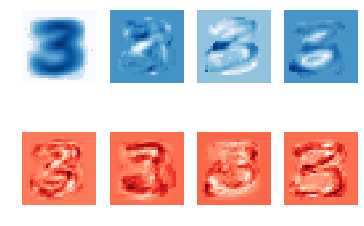

In [158]:
nc = 4
plt.subplot(2,nc,1)
#print(2,nc,1)
plt.imshow(wgts[2].reshape(28,28), interpolation='nearest',cmap='Blues')
plt.axis('off')


plt.subplot(2,nc, 1 + nc)
#print(2,nc, 1 + nc)
plt.imshow(changes[2].reshape(28,28), interpolation='nearest',cmap='Reds')
plt.axis('off')
col_counter = 1

for c in range(2, nc + 1):
    i = rng.randint(minibatch_size) # random choice of hidden node
    
    plt.subplot(2, nc, 1 + col_counter)
    #print(2,nc, 1 + col_counter)
    plt.imshow(wgts[0][i].reshape(28,28), interpolation='nearest',cmap='Blues')
    plt.axis('off')
    
    plt.subplot(2, nc, 1 + nc + col_counter)
    #print(2, nc, 1 + nc + col_counter)
    plt.imshow(changes[0][i].reshape(28,28), interpolation='nearest',cmap='Reds')
    plt.axis('off')
    col_counter += 1
print("Row 1 is weights, row 2 is changes. The first column is the bias. ")

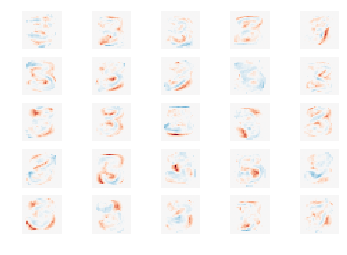

In [159]:
i=0
mx = np.max(np.abs(W))
for r in range(5):
    for c in range(5):
        plt.subplot(5,5,i+1)
        plt.imshow(W[i].reshape(28,28), interpolation='nearest',cmap='RdBu', vmin=-mx, vmax=mx)
        plt.axis('off')
        i += 1

## dreams
I think I'll try some "dreams" that start on actual training patterns.
I'll show them (but less and less often) as the Gibbs chain random-walks away from this initial point, and see how they diverge, and what they diverge TO.

So, presumably we should see them falling away from their initial state into the land of dreams as the model loses track of where it started from.

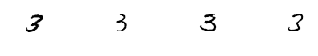

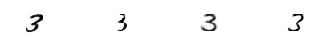

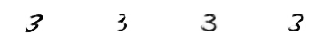

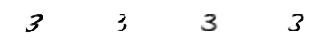

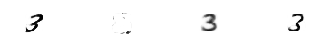

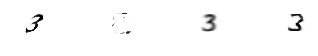

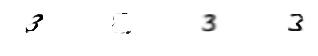

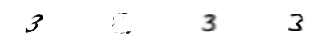

In [160]:
num_examples = 4
Vis_test = np.copy(vis_train_pats[rng.randint(0, num_pats, size=(num_examples)), :])
i = 0
num_Gibbs = 0
num_rows = 8
for s in range(num_rows):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(Vis_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(num_rows,num_examples,i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', vmin=0., vmax=1., interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 4)  # wait X times longer each time before showing the next sample.
    plt.show()

And now starting from some truly random initial patterns..............

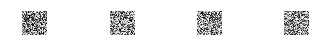

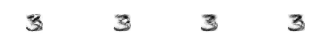

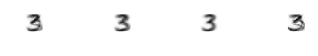

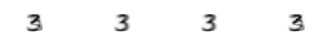

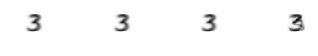

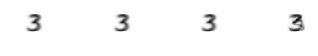

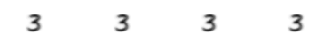

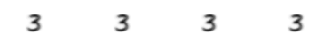

In [161]:
num_examples = 4
Vis_test = rng.random(size=(num_examples, num_visibles))
i = 0
num_Gibbs = 0
num_rows = 8
for s in range(num_rows):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(Vis_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(num_rows, num_examples, i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', vmin=0., vmax=1., interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 4)  # wait longer before showing the next sample...
    plt.show()

In [162]:
np.savez('./RBM_3s_weights.npz', W=W, hid_bias=hid_bias, vis_bias=vis_bias)

## 30 years of trial and error
(David Balduzzi's talk)

architecture: 
   * conv/weight tying
   * max-pooling
   
nonlinearity:
   * ReLU

Credit assignment:
   * backprop

Optimization:
   * stochastic Grad Desc
   * Nesterov momentum, BFGS, AdaGrad etc.
   * RMSProp

Regularisation:
   * Dropout (Srivastava 2014), OR....
   * Batch-Normalisation (2015)